In [54]:
# conda create -c conda-forge -n pymc_test "pymc>=4"
# conda activate pymc_test

In [55]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import graphviz
import seaborn as sns
import sklearn
import sklearn.pipeline
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2019-09-15")
max_date = pd.to_datetime("2023-02-19")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 179


In [57]:
eo = pd.read_csv('C:/Users/norri/Desktop/eo.csv')

from sklearn.preprocessing import MinMaxScaler
data = eo
# define min max scaler
scaler = MinMaxScaler()
# transform data
eo = scaler.fit_transform(data)
print(eo)

# print(scaler.fit(data))
# # #
# print(scaler.data_max_)
# #
# print(scaler.transform(data))

# print(scaler.transform([[0, 1]]))

# eo = scaler.transform([[2, 2]])

[[1.26448986e-01 3.71635976e-01]
 [4.10181860e-02 1.43813761e-01]
 [5.35269749e-02 2.07882148e-01]
 [1.61001368e-01 3.38089672e-01]
 [2.46263516e-01 4.96446414e-01]
 [2.63634722e-01 4.55429215e-01]
 [1.70037341e-01 3.60597011e-01]
 [1.69020675e-01 3.38661673e-01]
 [1.68635863e-01 3.02383881e-01]
 [1.65944549e-01 2.74763621e-01]
 [1.68951789e-01 3.09081025e-01]
 [1.67711837e-01 3.15747977e-01]
 [1.67388784e-01 3.07183263e-01]
 [1.58576098e-01 2.92852232e-01]
 [2.18461984e-01 3.80321659e-01]
 [2.18518994e-01 3.89064868e-01]
 [2.08656386e-01 4.21284187e-01]
 [1.84988028e-01 3.64045948e-01]
 [1.37580051e-01 2.42624268e-01]
 [1.46915322e-01 2.81927096e-01]
 [2.04128898e-01 3.30820732e-01]
 [2.19409764e-01 3.25428950e-01]
 [2.42833457e-01 3.64262182e-01]
 [4.77830511e-01 3.55034077e-01]
 [3.49880280e-01 3.33194617e-01]
 [8.88038500e-01 2.64636308e-01]
 [6.99093077e-01 2.90122784e-01]
 [4.70086749e-01 2.32515927e-01]
 [3.90311746e-01 1.73389513e-01]
 [4.89253748e-01 2.47078695e-01]
 [8.407089

In [58]:
# media data
# x1 = rng.uniform(low=0.0, high=1.0, size=n)
# df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)
df["x1"] = eo[:,0]
# TODO: fix the second line if need be

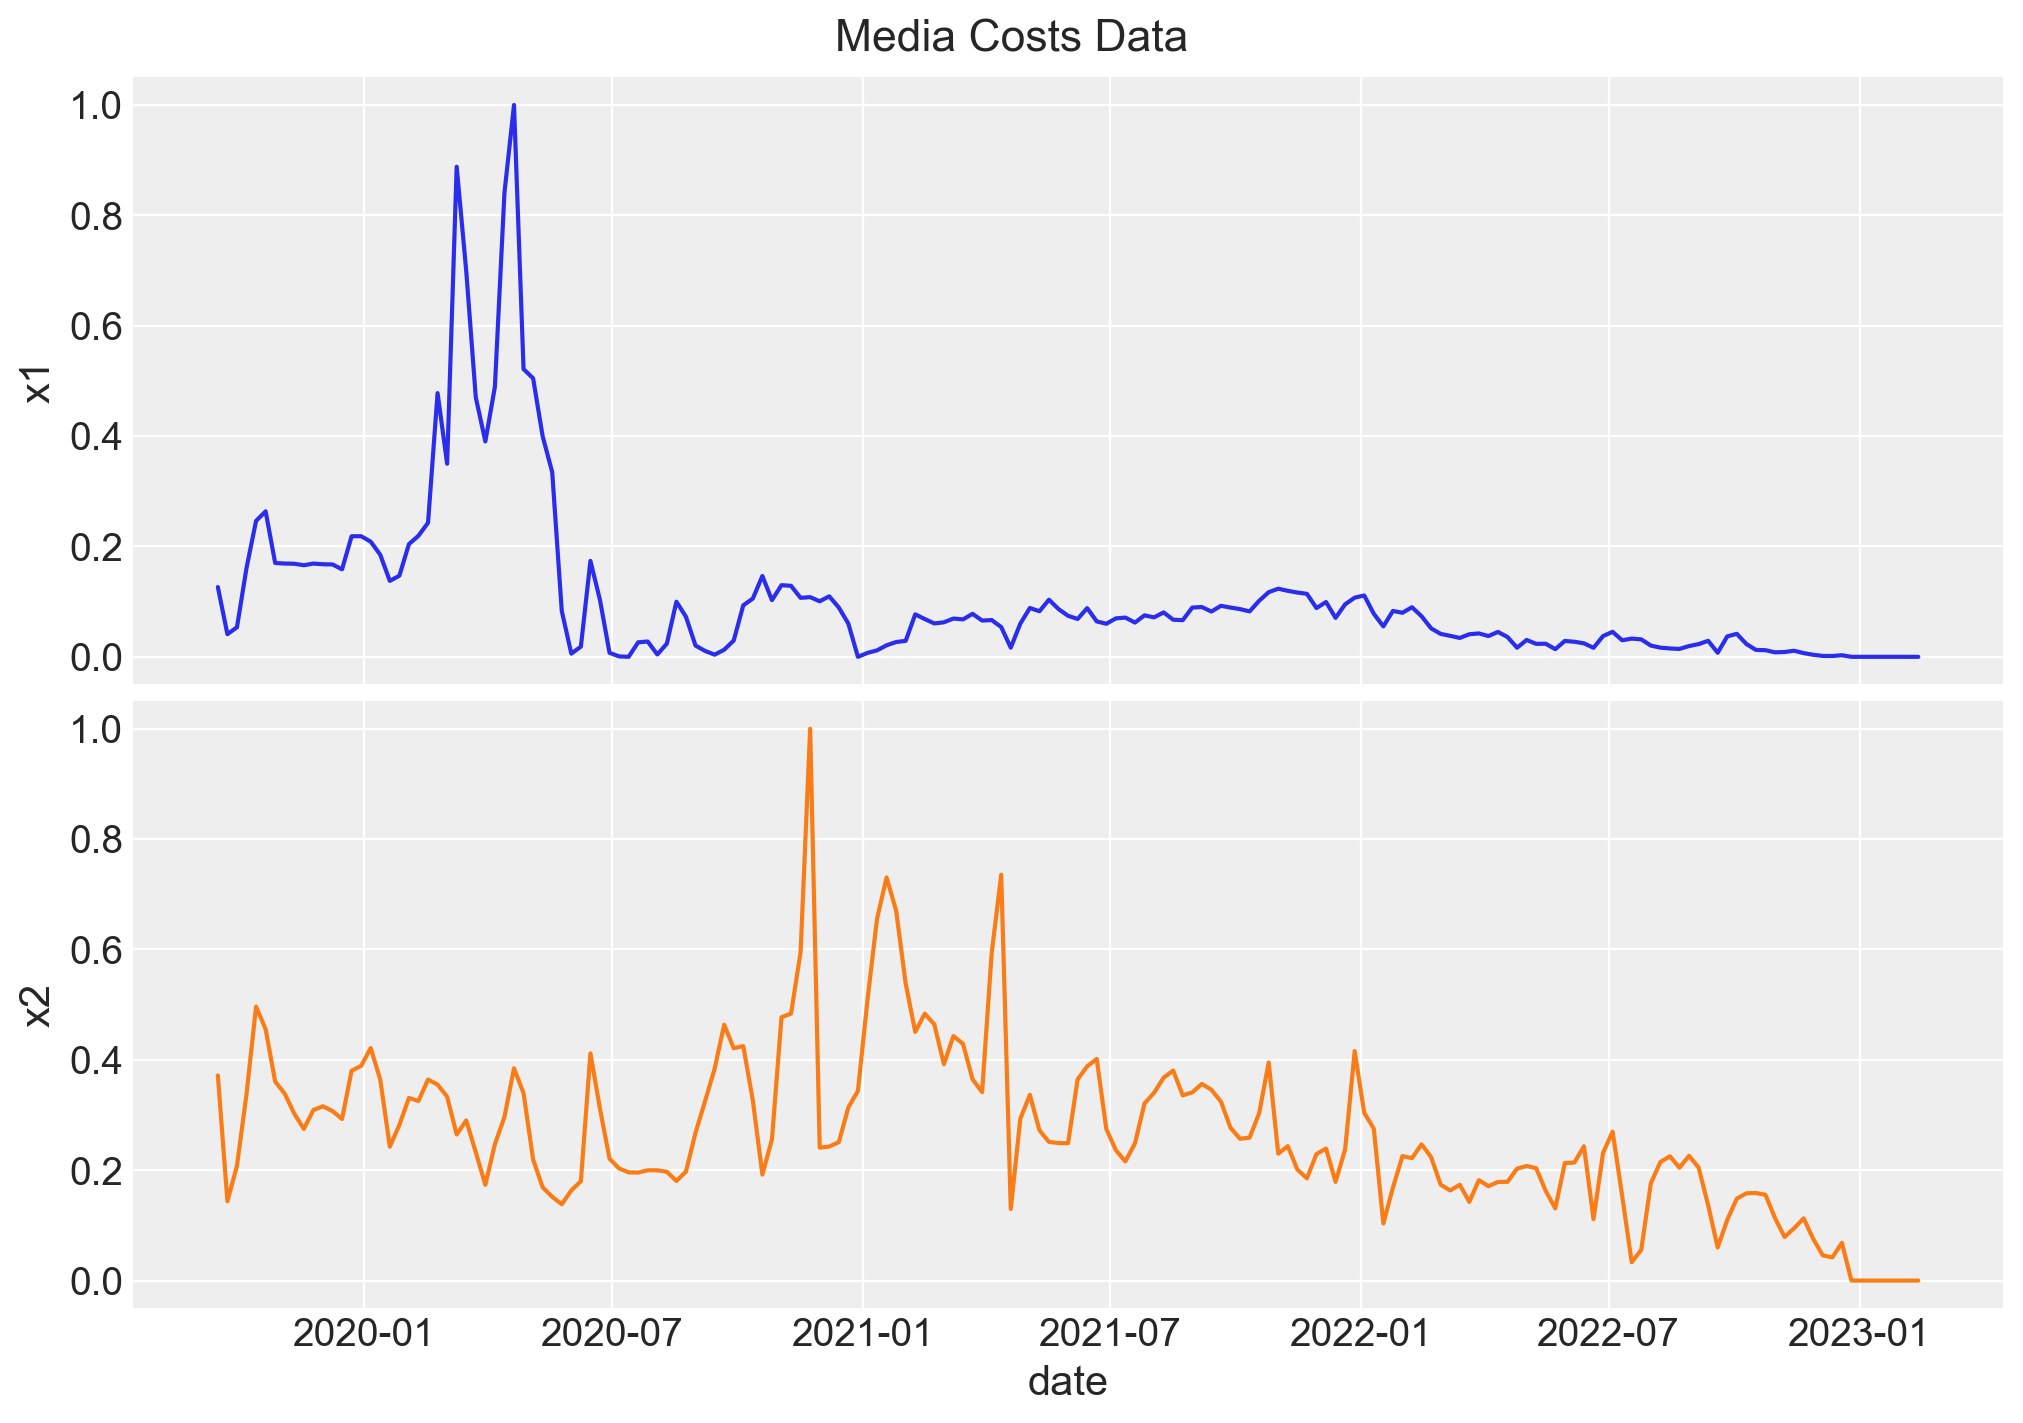

In [59]:
# x2 = rng.uniform(low=0.0, high=1.0, size=n)
# df["x2"] = np.where(x2 > 0.8, x2, 0)
# TODO: Fix the second line again
# x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = eo[:,1]

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

In [60]:
# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

df["x1_adstock"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
    .eval()
    .flatten()
)

In [61]:
# apply saturation transformation
lam1: float = 4.0
lam2: float = 3.0

df["x1_adstock_saturated"] = logistic_saturation(
    x=df["x1_adstock"].to_numpy(), lam=lam1
).eval()

df["x2_adstock_saturated"] = logistic_saturation(
    x=df["x2_adstock"].to_numpy(), lam=lam2
).eval()

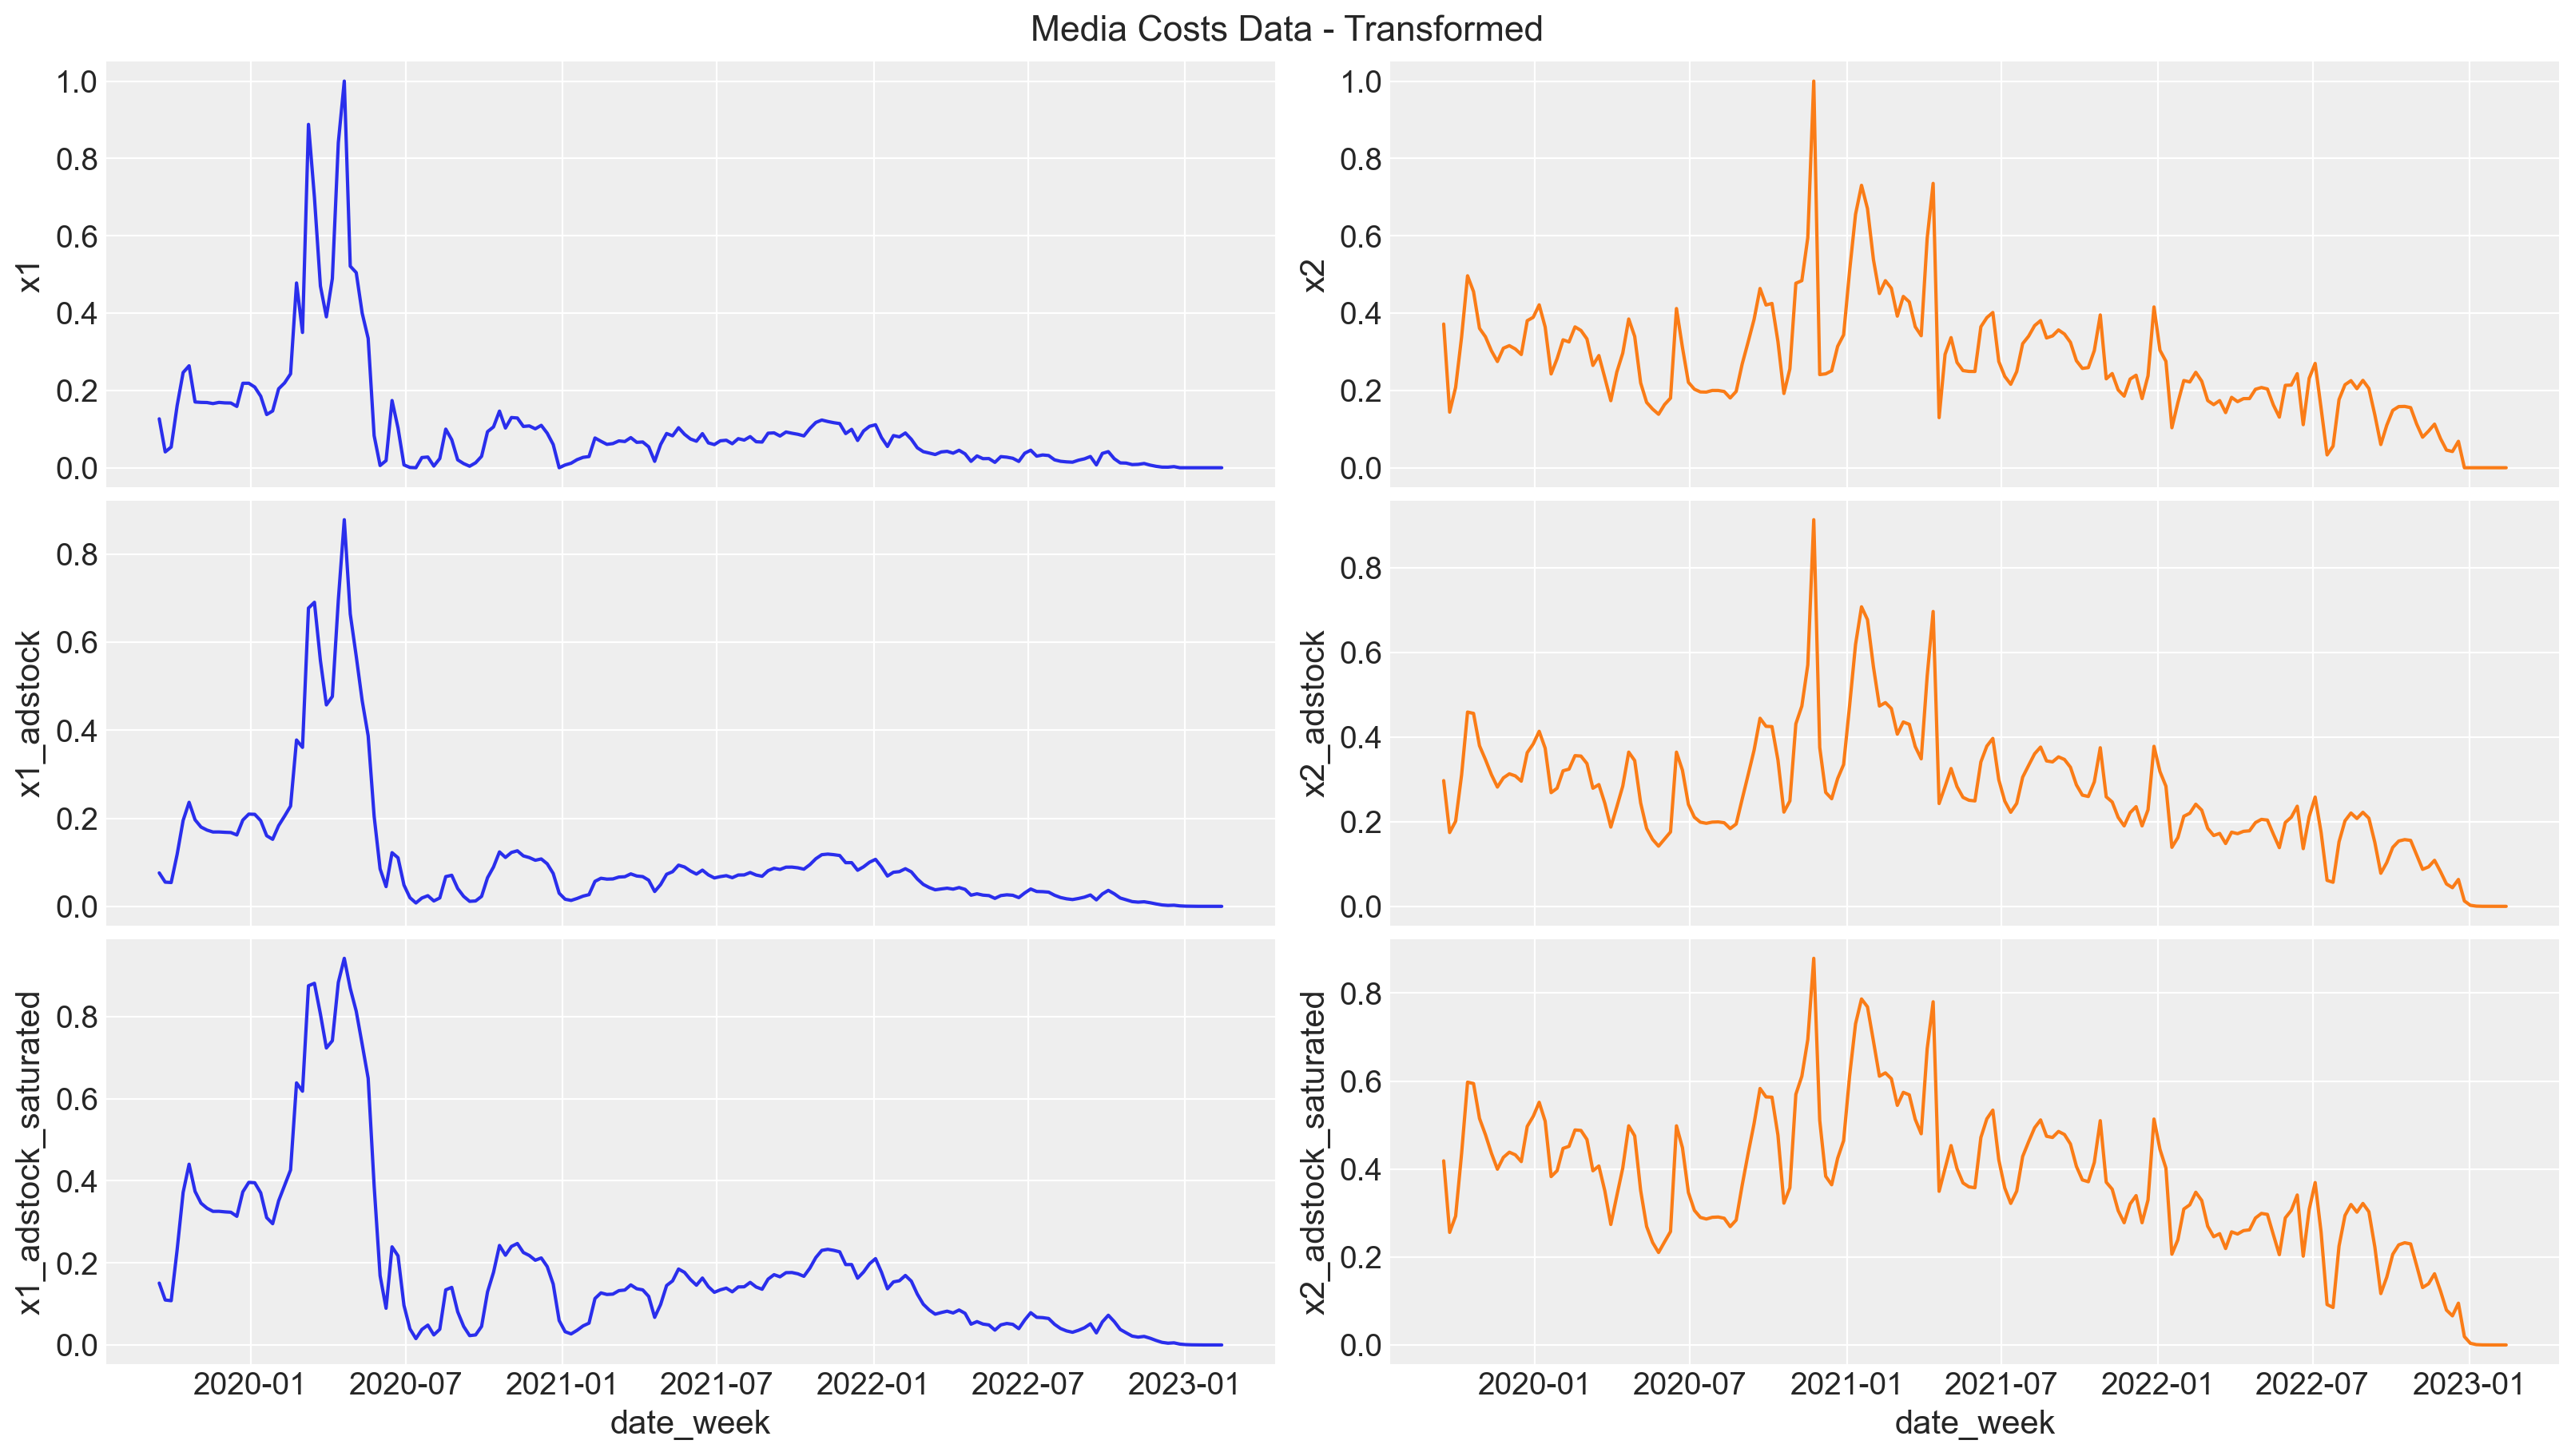

In [62]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="x1_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="x2_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="x1_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="x2_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16);

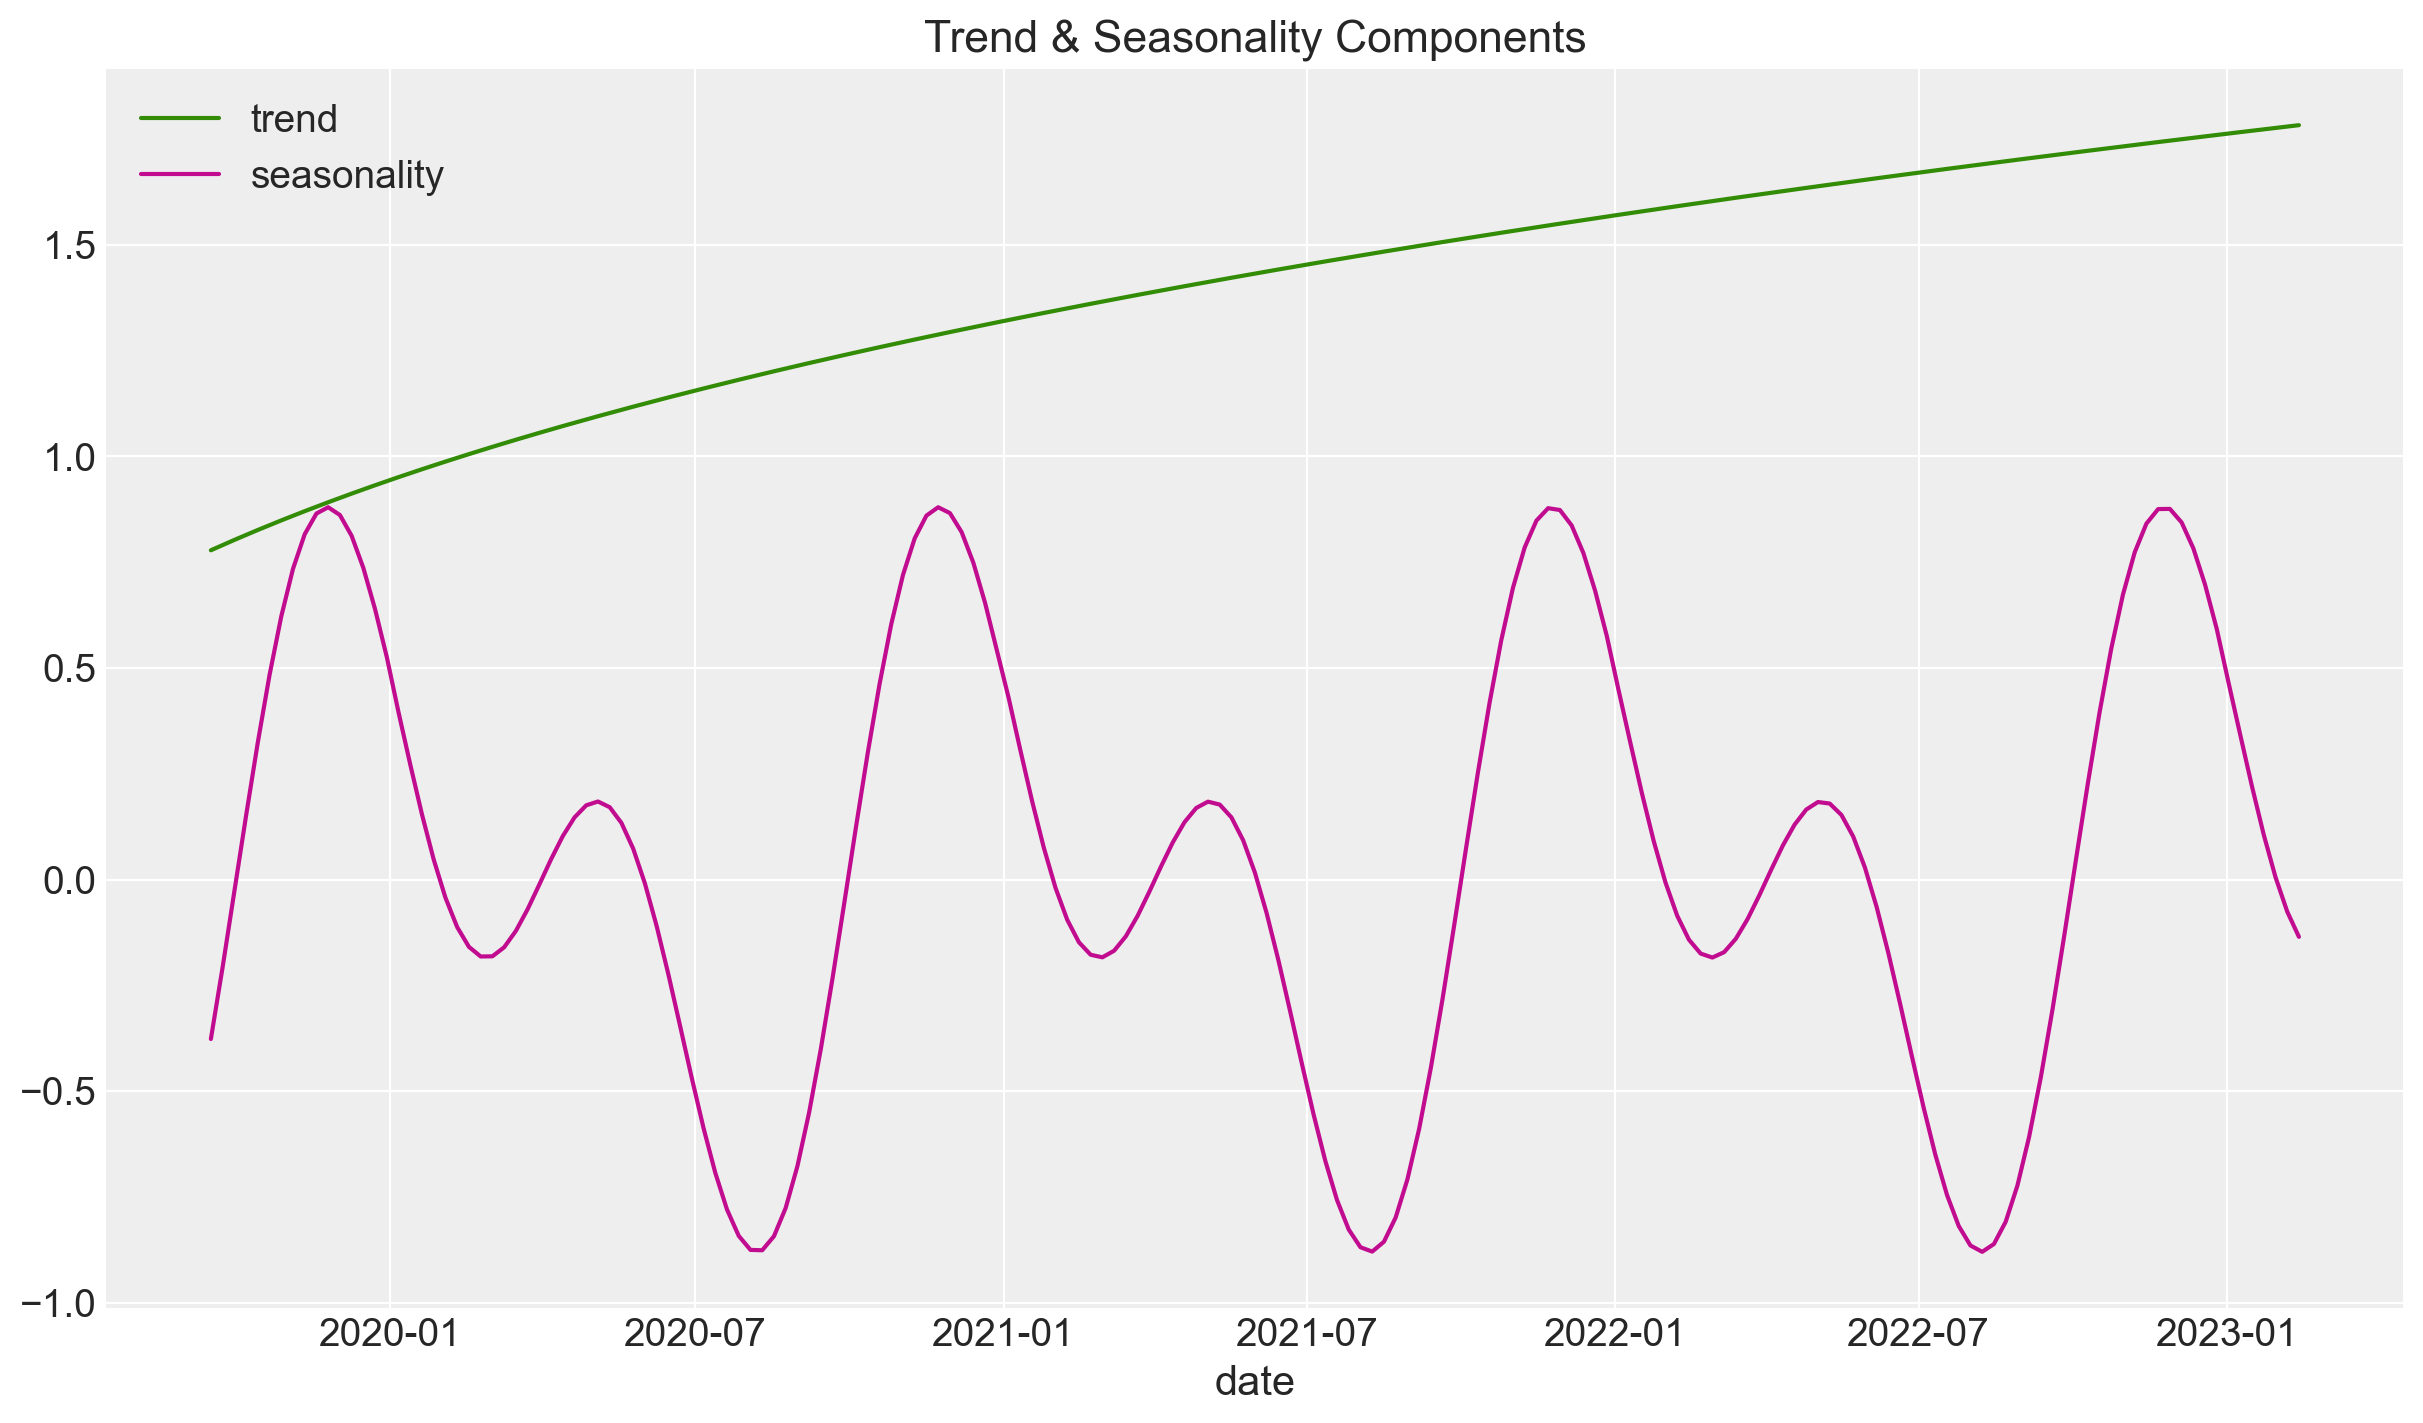

In [63]:
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1
# TODO: Find out how realistic seasonality and trend are
df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C2", label="trend", data=df, ax=ax)
sns.lineplot(
    x="date_week", y="seasonality", color="C3", label="seasonality", data=df, ax=ax
)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None);

In [64]:
df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

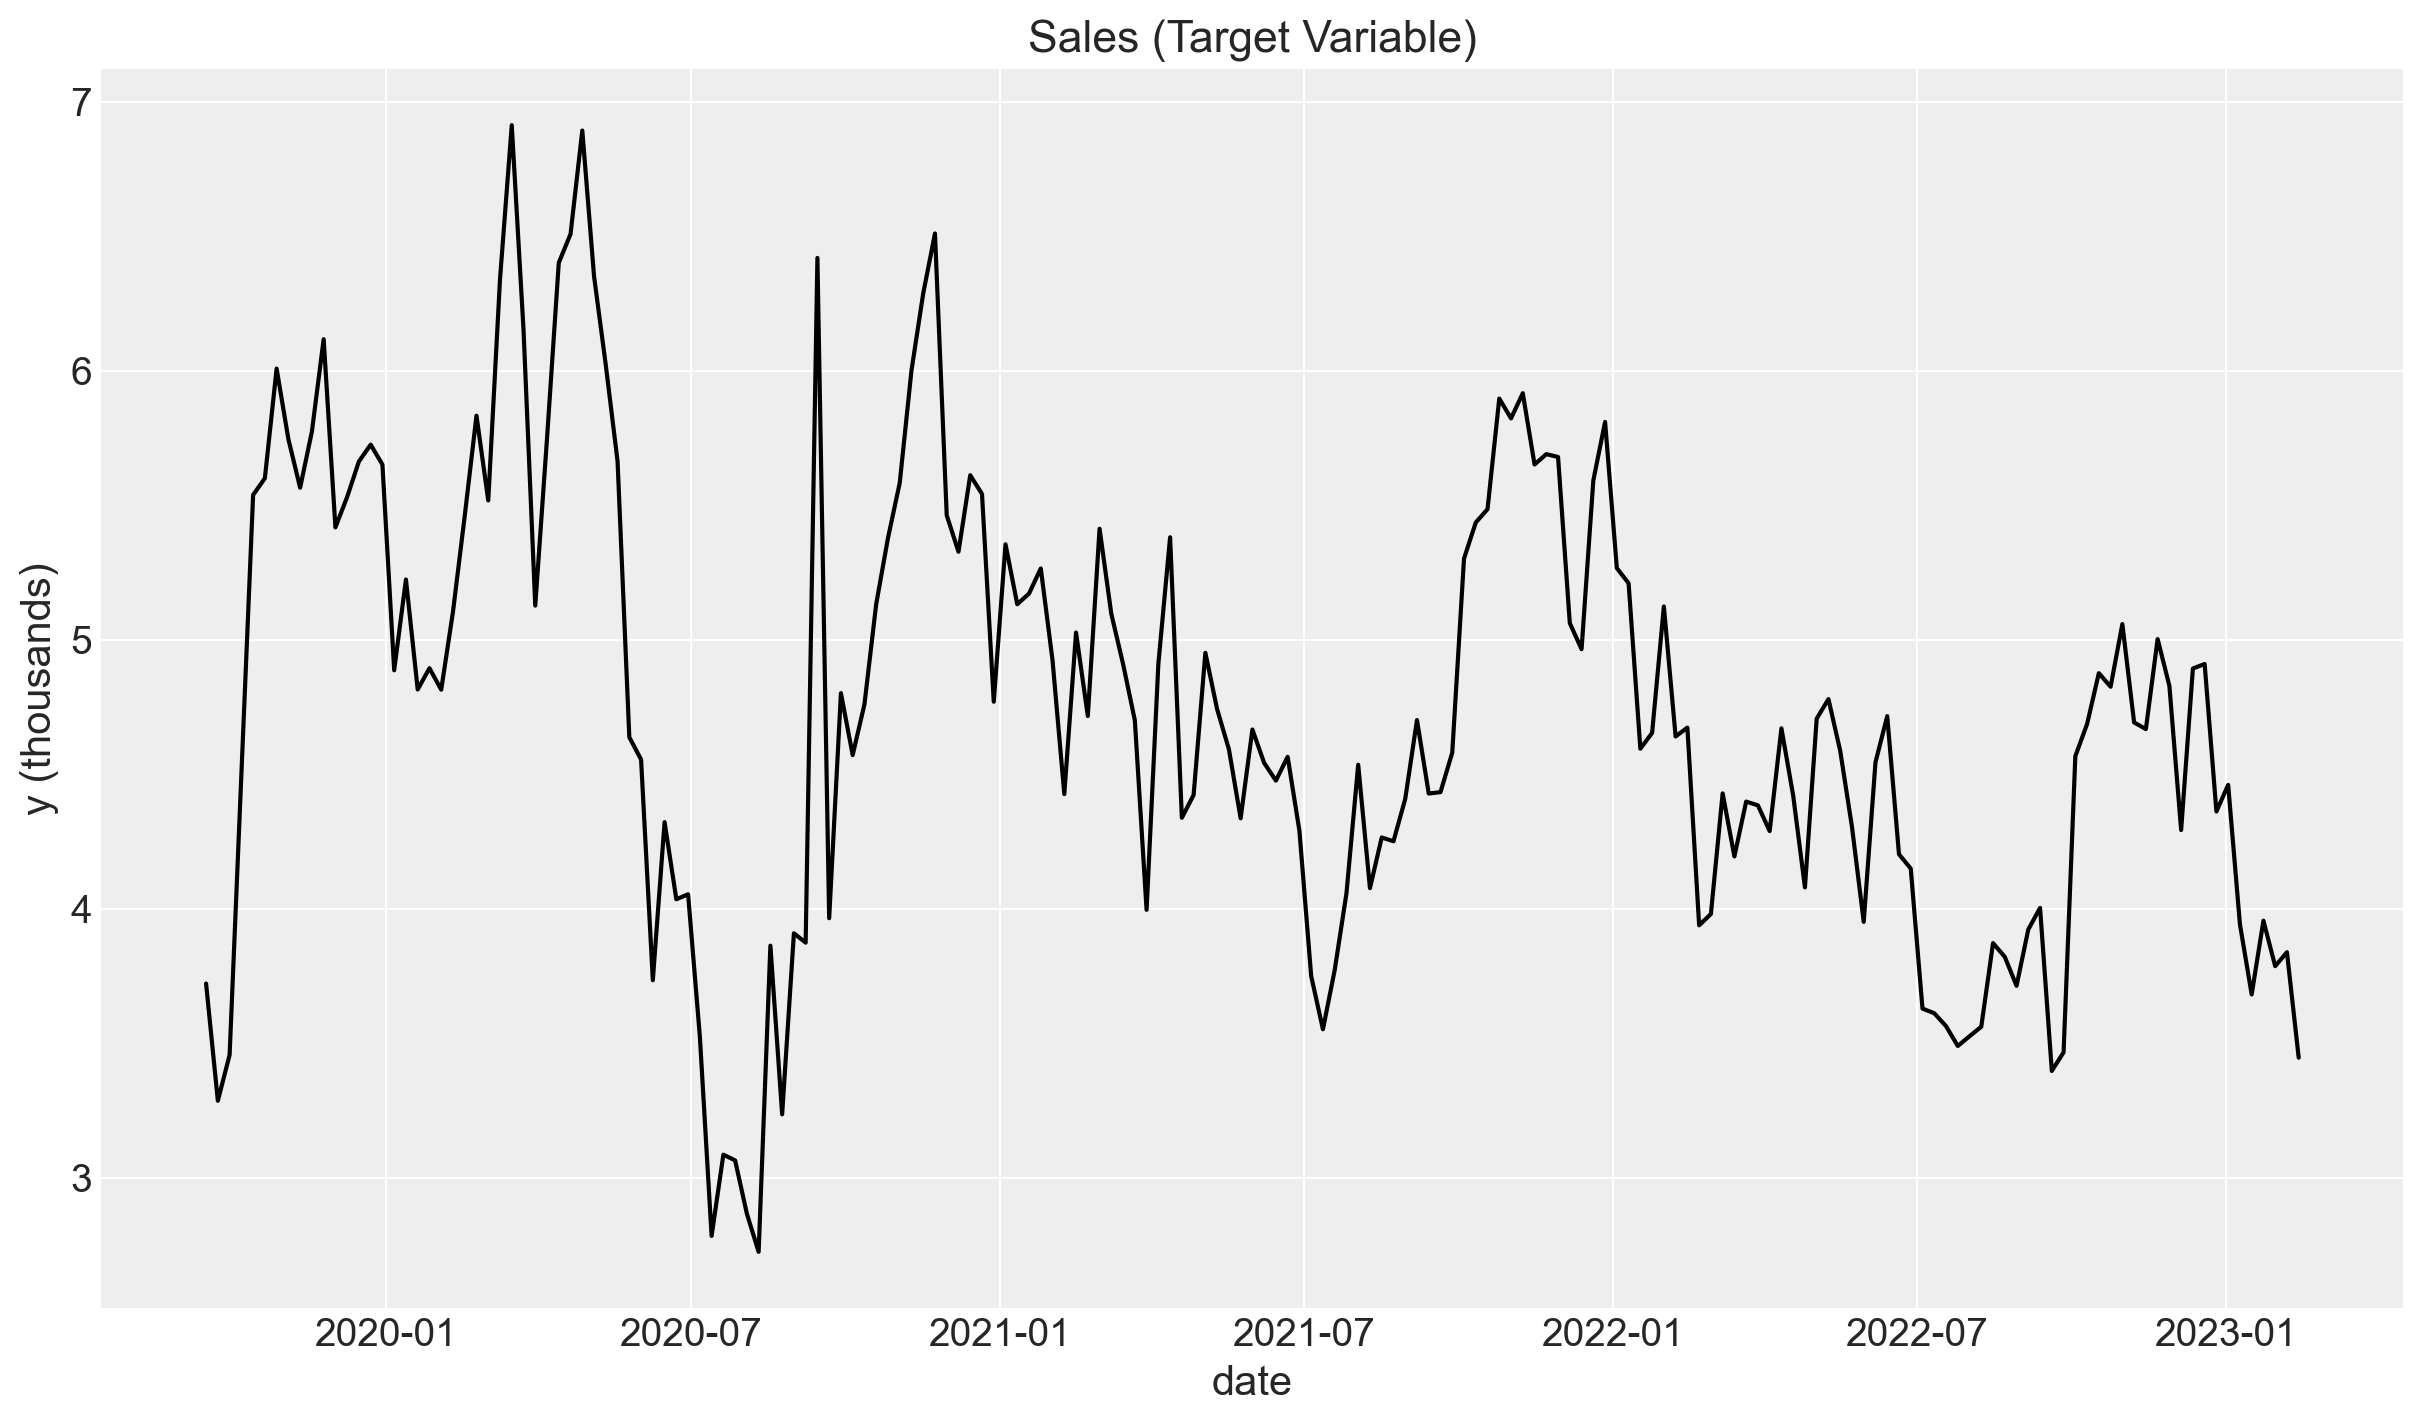

In [65]:
df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

amplitude = 1
beta_1 = 3.0
beta_2 = 2.0
betas = [beta_1, beta_2]


df["y"] = amplitude * (
        df["intercept"]
        + df["trend"]
        + df["seasonality"]
        + 1.5 * df["event_1"]
        + 2.5 * df["event_2"]
        + beta_1 * df["x1_adstock_saturated"]
        + beta_2 * df["x2_adstock_saturated"]
        + df["epsilon"]
)

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y (thousands)");

In [66]:
contribution_share_x1: float = (beta_1 * df["x1_adstock_saturated"]).sum() / (
        beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]
).sum()

contribution_share_x2: float = (beta_2 * df["x2_adstock_saturated"]).sum() / (
        beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]
).sum()

print(f"Contribution Share of x1: {contribution_share_x1:.2f}")
print(f"Contribution Share of x2: {contribution_share_x2:.2f}")

Contribution Share of x1: 0.43
Contribution Share of x2: 0.57


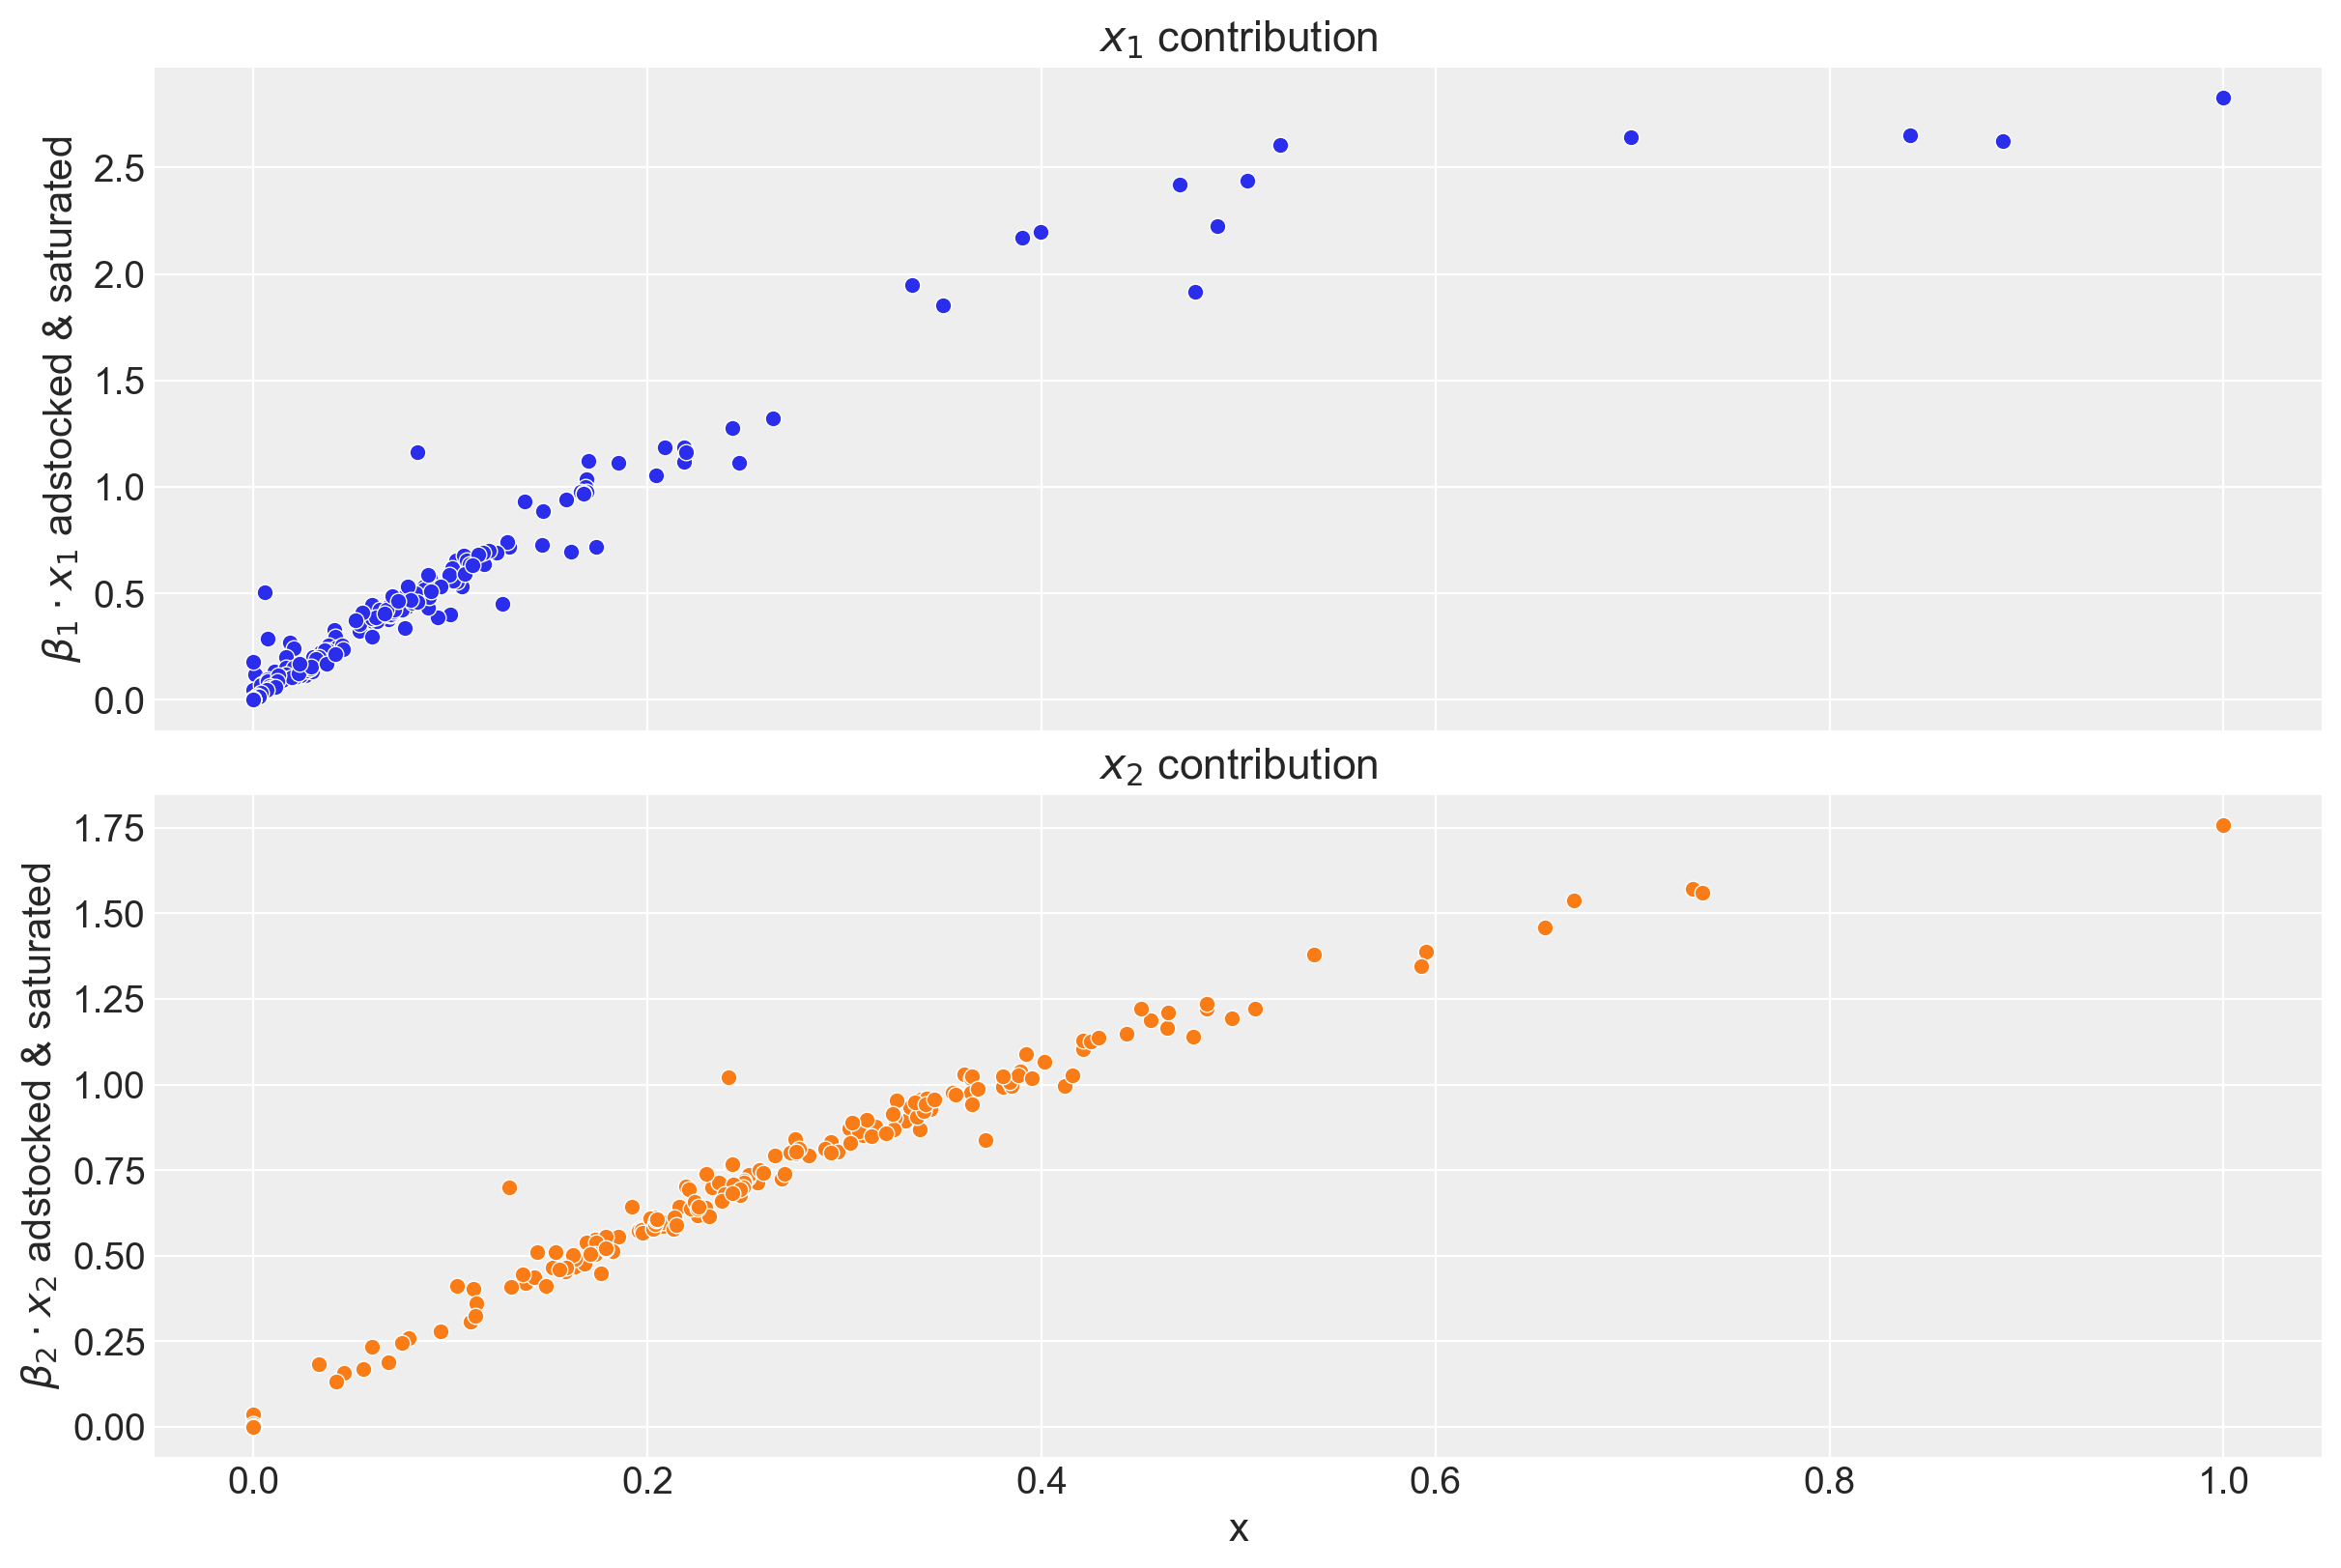

In [67]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 8), sharex=True, sharey=False, layout="constrained"
)

for i, x in enumerate(["x1", "x2"]):
    sns.scatterplot(
        x=df[x],
        y=amplitude * betas[i] * df[f"{x}_adstock_saturated"],
        color=f"C{i}",
        ax=ax[i],
    )
    ax[i].set(
        title=f"$x_{i + 1}$ contribution",
        ylabel=f"$\\beta_{i + 1} \cdot x_{i + 1}$ adstocked & saturated",
        xlabel="x",
    )

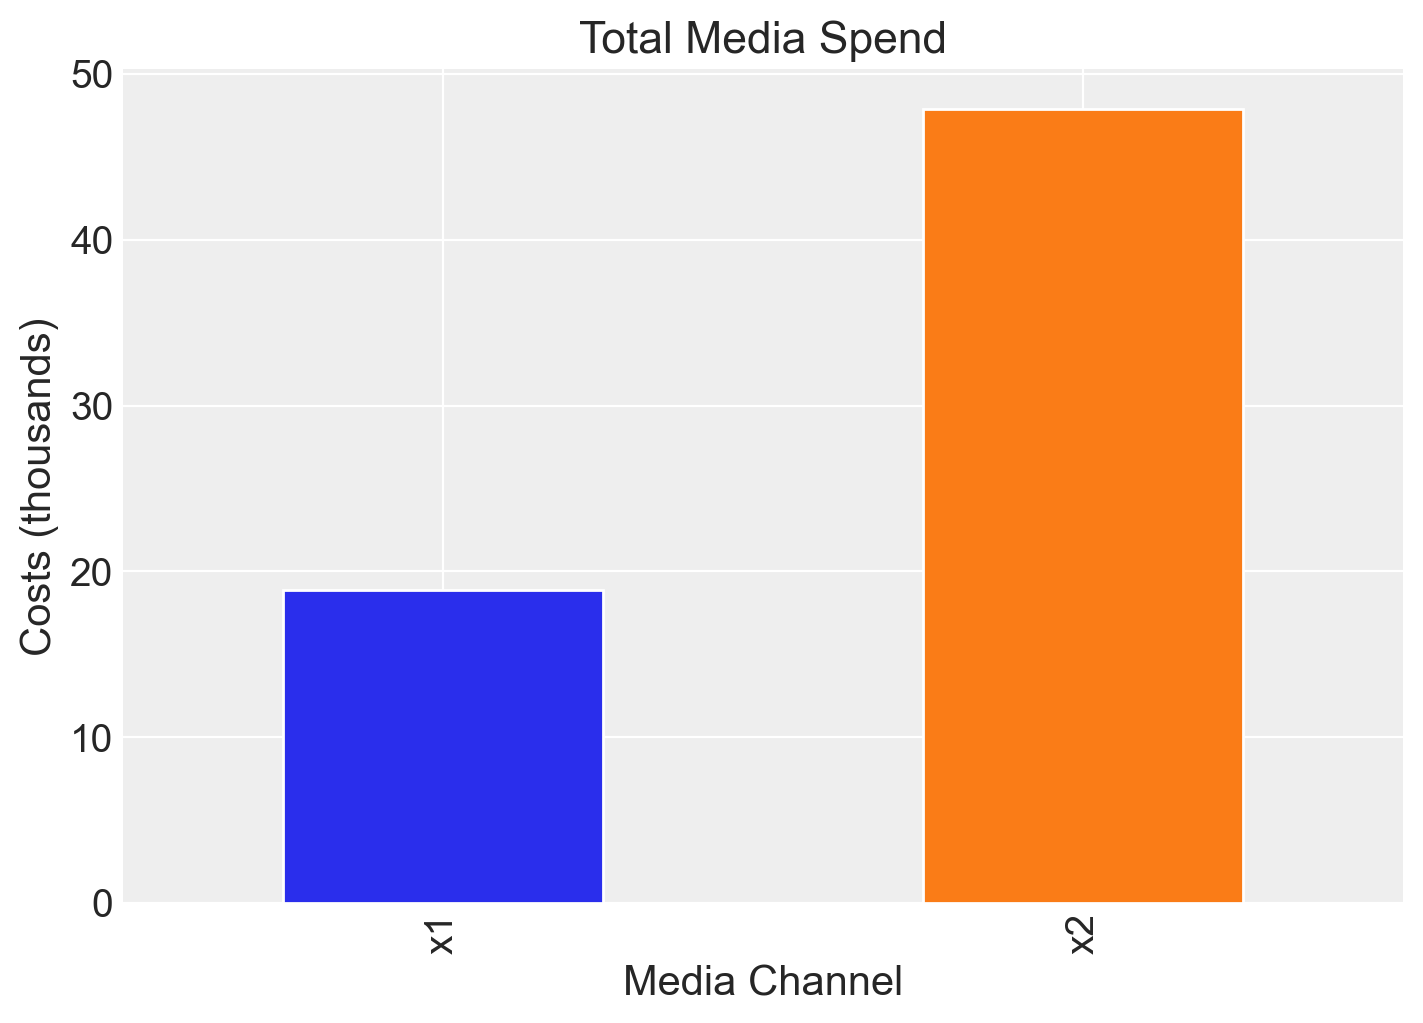

In [68]:
fig, ax = plt.subplots(figsize=(7, 5))
df[["x1", "x2"]].sum().plot(kind="bar", color=["C0", "C1"], ax=ax)
ax.set(title="Total Media Spend", xlabel="Media Channel", ylabel="Costs (thousands)");

In [69]:
roas_1 = (amplitude * beta_1 * df["x1_adstock_saturated"]).sum() / df["x1"].sum()
roas_2 = (amplitude * beta_2 * df["x2_adstock_saturated"]).sum() / df["x2"].sum()

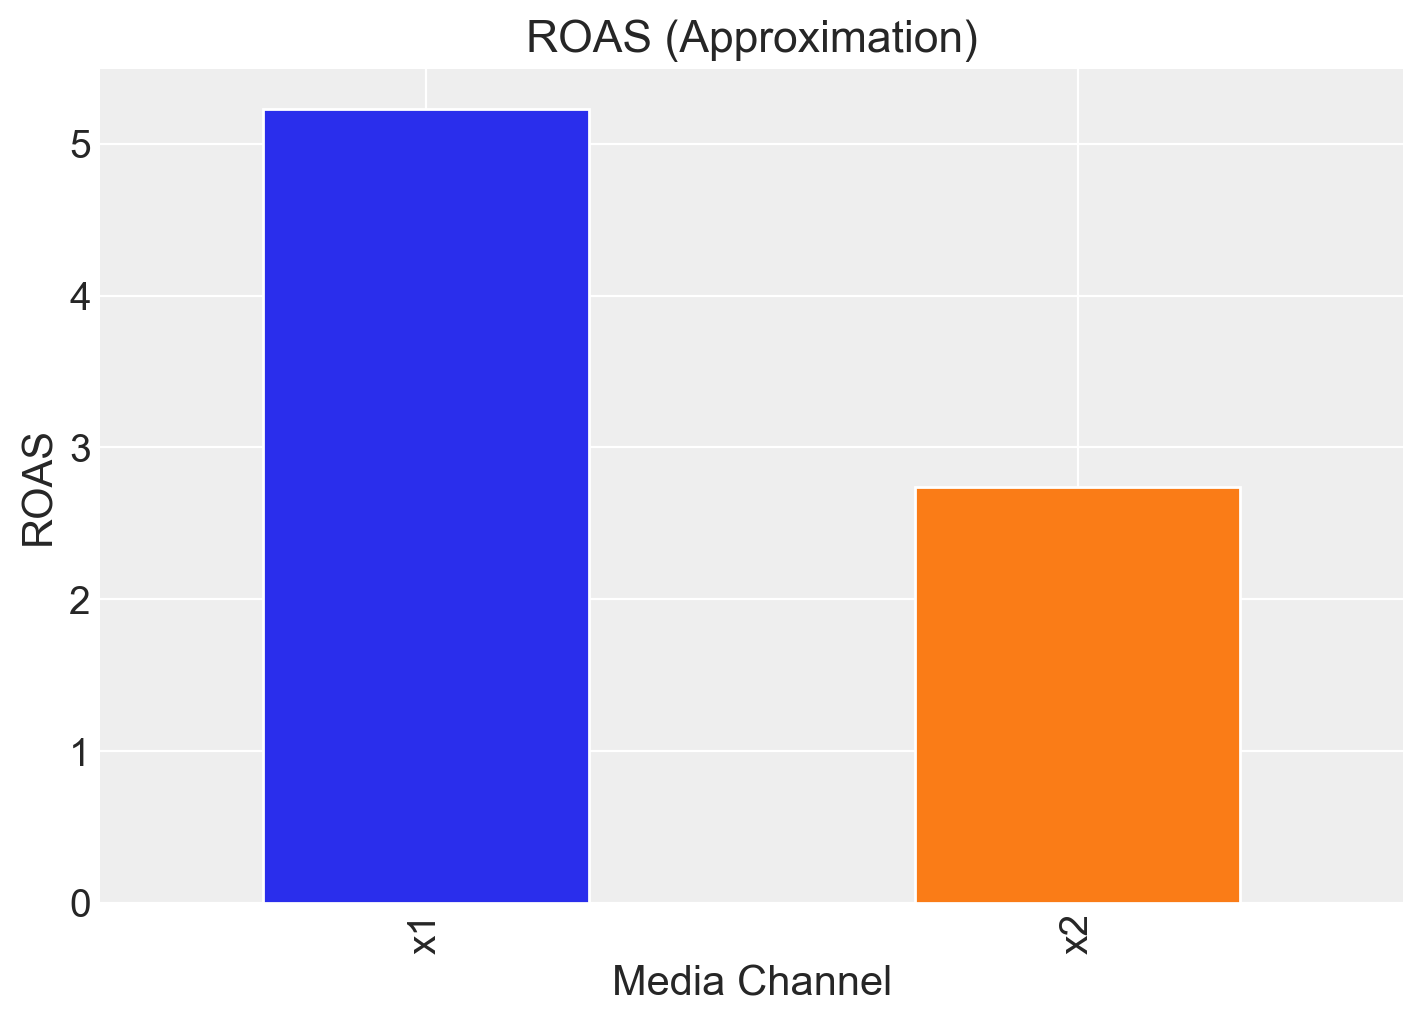

In [70]:
fig, ax = plt.subplots(figsize=(7, 5))
(
    pd.Series(data=[roas_1, roas_2], index=["x1", "x2"]).plot(
        kind="bar", color=["C0", "C1"]
    )
)

ax.set(title="ROAS (Approximation)", xlabel="Media Channel", ylabel="ROAS");

In [71]:
columns_to_keep = [
    "date_week",
    "y",
    "x1",
    "x2",
    "event_1",
    "event_2",
    "dayofyear",
]

data = df[columns_to_keep].copy()

data.head()

,date_week,y,x1,x2,event_1,event_2,dayofyear
0,2019-09-16,3.722275,0.126449,0.371636,0.0,0.0,259
1,2019-09-23,3.286461,0.041018,0.143814,0.0,0.0,266
2,2019-09-30,3.456967,0.053527,0.207882,0.0,0.0,273
3,2019-10-07,4.501240,0.161001,0.338090,0.0,0.0,280
4,2019-10-14,5.538472,0.246264,0.496446,0.0,0.0,287


In [72]:
# trend feature
data["t"] = range(n)

data.head()

,date_week,y,x1,x2,event_1,event_2,dayofyear,t
0,2019-09-16,3.722275,0.126449,0.371636,0.0,0.0,259,0
1,2019-09-23,3.286461,0.041018,0.143814,0.0,0.0,266,1
2,2019-09-30,3.456967,0.053527,0.207882,0.0,0.0,273,2
3,2019-10-07,4.501240,0.161001,0.338090,0.0,0.0,280,3
4,2019-10-14,5.538472,0.246264,0.496446,0.0,0.0,287,4


In [73]:
mmm = DelayedSaturatedMMM(
    data=data,
    target_column="y",
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    adstock_max_lag=8,
    yearly_seasonality=2,
)

In [74]:
type(mmm.model)

pymc.model.Model

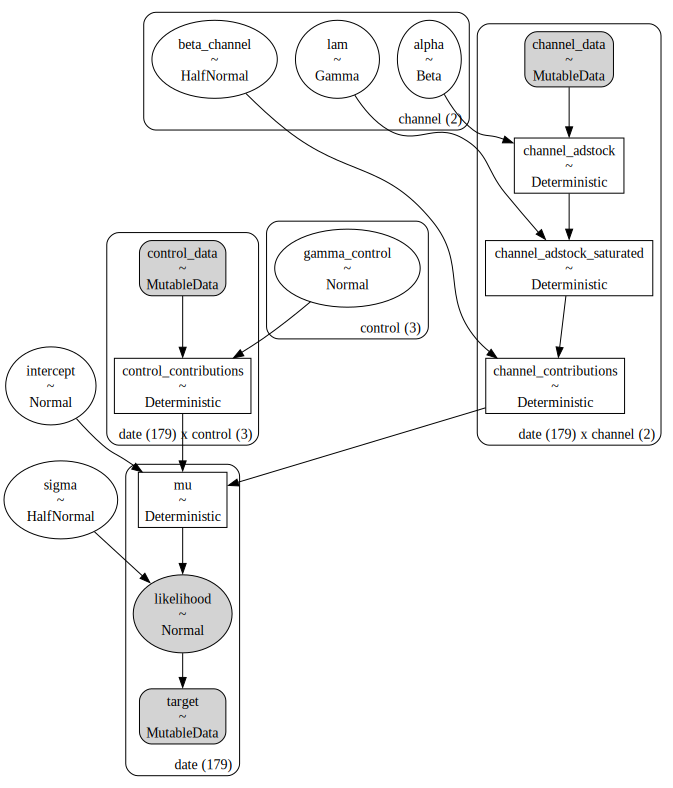

In [75]:
pm.model_to_graphviz(model=mmm.model)

In [76]:
mmm.fit(target_accept=0.95, chains=4, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, sigma, gamma_control]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Sampling: [likelihood]


In [77]:
mmm.fit_result

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [78]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "beta_channel",
        "alpha",
        "lam",
        "gamma_control",
        "gamma_fourier",
        "sigma",
    ],
)

KeyError: 'var names: "[\'gamma_fourier\'] are not present" in dataset'

In [ ]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "beta_channel",
        "alpha",
        "lam",
        "gamma_control",
        "gamma_fourier",
        "sigma",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

In [ ]:
mmm.plot_posterior_predictive(original_scale=True);

In [ ]:
mmm.plot_components_contributions();

In [ ]:
mmm.get_target_transformer()

In [ ]:
groups = {
    "Base": [
        "intercept",
        "event_1",
        "event_2",
        "t",
        "sin_order_1",
        "sin_order_2",
        "cos_order_1",
        "cos_order_2",
    ],
    "Channel 1": ["x1"],
    "Channel 2": ["x2"],
}

fig = mmm.plot_grouped_contribution_breakdown_over_time(
    stack_groups=groups,
    original_scale=True,
    area_kwargs={
        "color": {
            "Channel 1": "C0",
            "Channel 2": "C1",
            "Base": "gray",
            "Seasonality": "black",
        },
        "alpha": 0.7,
    },
)

fig.suptitle("Contribution Breakdown over Time", fontsize=16);

In [ ]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(original_scale=True)

get_mean_contributions_over_time_df.head()

In [ ]:
fig = mmm.plot_channel_parameter(param_name="alpha", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"$\alpha_1$")
ax.axvline(x=alpha2, color="C1", linestyle="--", label=r"$\alpha_2$")
ax.legend(loc="upper right");

In [ ]:
fig = mmm.plot_channel_parameter(param_name="lam", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=lam1, color="C0", linestyle="--", label=r"$\lambda_1$")
ax.axvline(x=lam2, color="C1", linestyle="--", label=r"$\lambda_2$")
ax.legend(loc="upper right");

In [ ]:
fig = mmm.plot_channel_contribution_share_hdi(figsize=(7, 5))
ax = fig.axes[0]
ax.axvline(
    x=contribution_share_x1,
    color="C1",
    linestyle="--",
    label="true contribution share ($x_1$)",
)
ax.axvline(
    x=contribution_share_x2,
    color="C2",
    linestyle="--",
    label="true contribution share ($x_2$)",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=1);

In [ ]:
fig = mmm.plot_contribution_curves()
[ax.set(xlabel="x") for ax in fig.axes];

In [ ]:
channels_contribution_original_scale = mmm.compute_channel_contribution_original_scale()
channels_contribution_original_scale_hdi = az.hdi(ary=channels_contribution_original_scale)

fig, ax = plt.subplots(
    nrows=2, figsize=(15, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

for i, x in enumerate(["x1", "x2"]):
    # Estimate true contribution in the original scale from the data generating process
    sns.lineplot(
        x=df["date_week"],
        y=amplitude * betas[i] * df[f"{x}_adstock_saturated"],
        color="black",
        label=f"{x} true contribution",
        ax=ax[i],
    )
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=df["date_week"],
        y1=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 0],
        y2=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 1],
        color=f"C{i}",
        label=f"{x} $94%$ HDI contribution",
        alpha=0.4,
    )
    # Mean estimated contribution in the original scale
    sns.lineplot(
        x=df["date_week"],
        y=get_mean_contributions_over_time_df[x].to_numpy(),
        color=f"C{i}",
        label=f"{x} posterior mean contribution",
        alpha=0.8,
        ax=ax[i],
    )
    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")

In [ ]:
channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()

roas_samples = (
        channel_contribution_original_scale.stack(sample=("chain", "draw")).sum("date")
        / data[["x1", "x2"]].sum().to_numpy()[..., None]
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    roas_samples.sel(channel="x1").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax
)
sns.histplot(
    roas_samples.sel(channel="x2").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax
)
ax.axvline(x=roas_1, color="C0", linestyle="--", label=r"true ROAS $x_{1}$")
ax.axvline(x=roas_2, color="C1", linestyle="--", label=r"true ROAS $x_{2}$")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS");